In [1]:
import yfinance as yf
from datetime import date, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fetching historical data for GEN from 2023-10-17 to 2025-10-16. 
 --- estimated geometric brownian motion (GBM) parameters for GEN ---
1. Current stock price (s0):  $27.040
2. The most recuent daily log return:  0.008
3. Annualized volatility (sigma)L 0.291


/var/folders/qk/hf8gg8mx2tg3jyv94_6z9phc0000gp/T/ipykernel_1617/464844447.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print( f'1. Current stock price (s0):  ${float(s0):,.3f}' )
/var/folders/qk/hf8gg8mx2tg3jyv94_6z9phc0000gp/T/ipykernel_1617/464844447.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print( f'2. The most recuent daily log return:  {float(current_log_return):,.3f}' )
/var/folders/qk/hf8gg8mx2tg3jyv94_6z9phc0000gp/T/ipykernel_1617/464844447.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print( f'3. Annualized volatility (sigma)L {float(sigma_estimate):,.3f}' )


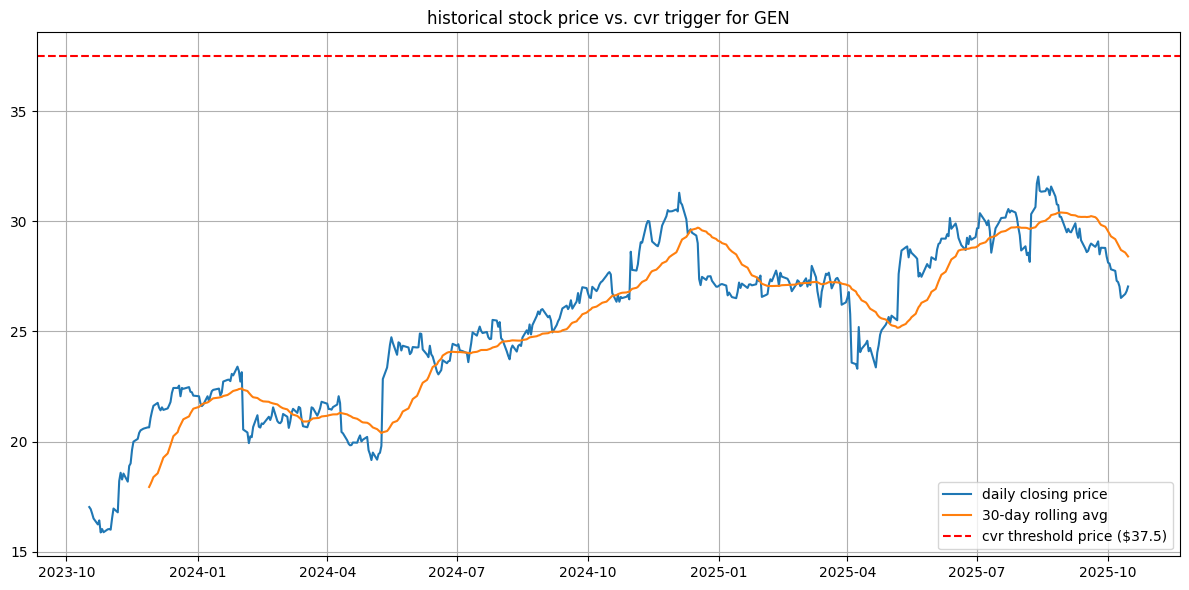

In [2]:
# fetch historical data for parameters
def historical_data_gbm( ticker: str, threshold: float, lookback_days: int = 30 ):

    # define date range
    today = date.today()
    start_date = today - timedelta( days = 2 * 365 )
    end_date = today.strftime( '%Y-%m-%d' )
    start_date_str = start_date.strftime( '%Y-%m-%d' )

    print( f'fetching historical data for {ticker} from {start_date_str} to {end_date}. ' )

    # dl data
    data = yf.download( ticker,
                       start = start_date_str,
                       end = end_date,
                       progress = False,
                       auto_adjust = True)
    # print(data)
    data.to_csv('gen.csv')

    # current stock price (s0)
    s0 = data['Close'].iloc[-1]

    # estimate volatility (sigma)
    log_returns = np.log( data['Close'] / data['Close'].shift(1) ).dropna()
    current_log_return = log_returns.iloc[-1]

    # cal. anualized volatility:  sigma = std.dev. * sqrt(252)
    daily_std = log_returns.std()
    sigma_estimate = daily_std * np.sqrt(252)

    print( f' --- estimated geometric brownian motion (GBM) parameters for {ticker} ---' )
    print( f'1. Current stock price (s0):  ${float(s0):,.3f}' )
    print( f'2. The most recuent daily log return:  {float(current_log_return):,.3f}' )
    print( f'3. Annualized volatility (sigma)L {float(sigma_estimate):,.3f}' )

    # visualize daily closing price
    plt.figure(figsize=(12, 6))
    plt.plot( data.index,
             data['Close'],
             label = 'daily closing price' )

    # plot 30-day rolling avg
    data[f'{lookback_days}d_rolling_avg'] = data['Close'].rolling(window=lookback_days).mean()
    plt.plot( data.index,
             data[f'{lookback_days}d_rolling_avg'],
            label = f'{lookback_days}-day rolling avg' )

    # plot cvr
    plt.axhline( y = threshold,
                linestyle = '--',
                color = 'red',
                label = f'cvr threshold price (${threshold})')

    # title
    plt.title( f'historical stock price vs. cvr trigger for {ticker}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

ticker = 'GEN'
threshold = 37.50
lookback_days = 30

historical_data_gbm(ticker, threshold, lookback_days)

Current GEN price: $27.04
Trigger price: $37.50
Volatility: 29.00%
Duration: 2.0 years
Simulations: 100,000
------------------------------------------


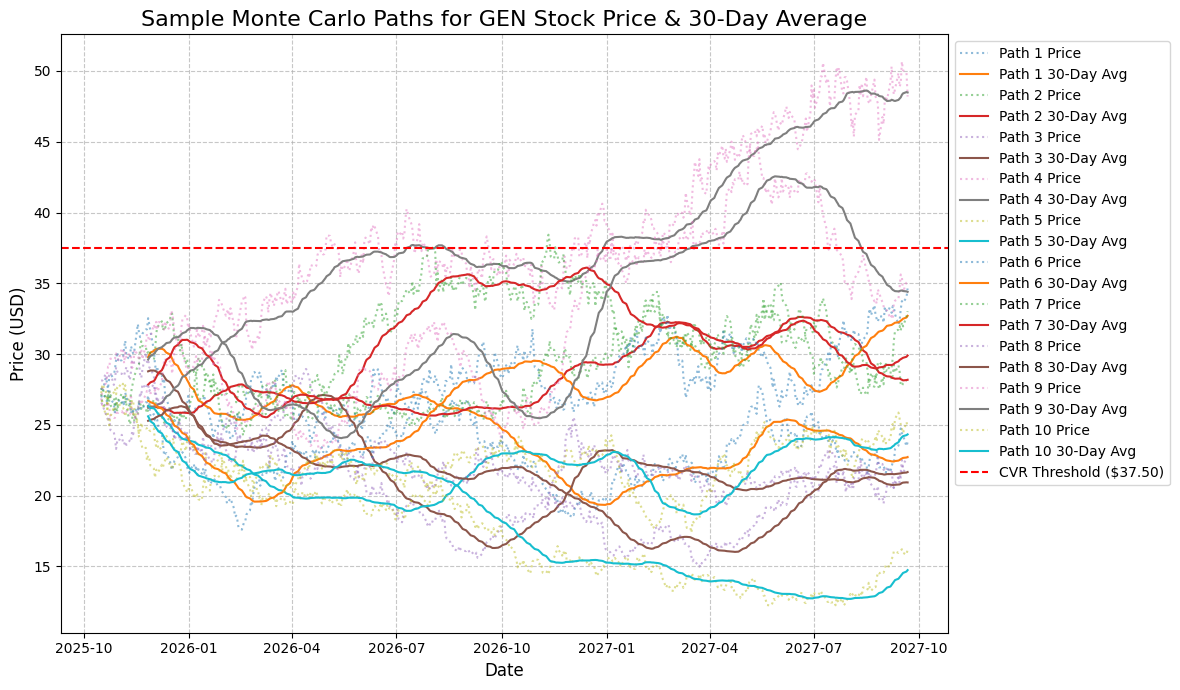

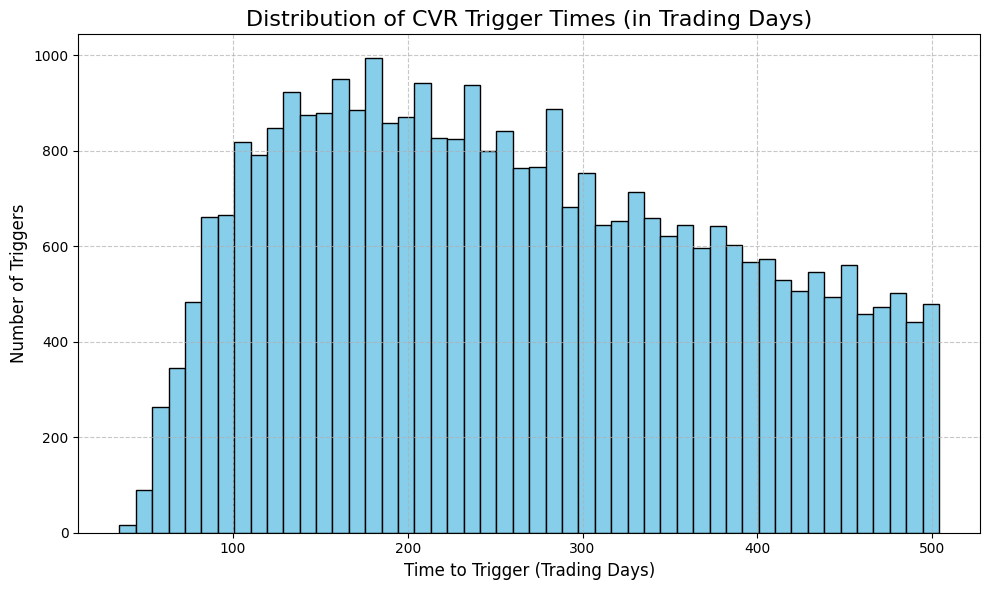

In [3]:
def cvr_gbm (
        s0: float,                  # current stock price
        rate_risk_free: float,
        volatility: float,          # the estimated annual stk. volatility
        duration: float,             # duration of the merger
        threshold: float,           # threshold price to trigger consecutive 30 days
        payout: float,              # what do you get
        simulations: int,           # how many Monte Carlo runs
        trading_days: int = 252,    # number of annual trading days
        consecutive_days: int = 30, # how many days to trigger
        num_paths_to_plot: int = 5, # New parameter for visualization
                                    # (zero for no visualization)
        random_seed: int = None,       # set to fixed integer for reproducible MC
) -> float:

    np.random.seed( seed=random_seed ) # set

    n = int(duration * trading_days)
    dt = 1 / trading_days

    brownian_drift = ( rate_risk_free - 0.5 * volatility**2 ) * dt
    volatility_jump = volatility * np.sqrt(dt)

    current_total = 0
    trigger_times = [] # store the time of trigger for histogram
    simulated_paths_for_plot = [] # store a few paths for visualization

    # monte carlo simulation
    for i in range(simulations):

        # generate a standard normal stk. price path
        z = np.random.standard_normal(n)
        daily_return = brownian_drift + volatility_jump * z

        cum_return = np.cumprod( np.concatenate(([1.0], np.exp(daily_return))) )
        path = s0 * cum_return[1:]

        trigger_found = False
        time_to_trigger = duration

        # check path for trigger (30-day avg.)
        for j in range(consecutive_days - 1, n):
            avg_price = np.mean( path[j - consecutive_days + 1 : j + 1] )

            if avg_price >= threshold:
                trigger_found = True
                trigger_step = j + 1
                time_to_trigger = trigger_step * dt
                break

        # cal. the payoff upon trigger
        payoff = 0
        if trigger_found:
            payoff = payout * np.exp( - rate_risk_free * time_to_trigger)
            trigger_times.append(time_to_trigger) # Record trigger time
        current_total += payoff

        # Store a few paths for visualization
        if i < num_paths_to_plot:
            simulated_paths_for_plot.append(path)

        # cal. cvr
    cvr = current_total / simulations

    if num_paths_to_plot > 0:
        # --- VISUALIZATIONS ---

        # Generate dates for x-axis
        # Start from today and go for the duration
        start_date_plot = pd.Timestamp.now().normalize()
        dates = pd.date_range(start=start_date_plot, periods=n, freq='B') # 'B' for business day

        # Plot 1: A Few Simulated Paths with Rolling Average and Threshold
        plt.figure(figsize=(14, 7))

        for i, path_to_plot in enumerate(simulated_paths_for_plot):
            df_plot = pd.DataFrame({'Close': path_to_plot}, index=dates)
            df_plot['Rolling_Avg'] = df_plot['Close'].rolling(window=consecutive_days).mean()

            plt.plot(df_plot.index, df_plot['Close'], label=f'Path {i+1} Price', alpha=0.5, linestyle=':')
            plt.plot(df_plot.index, df_plot['Rolling_Avg'], label=f'Path {i+1} {consecutive_days}-Day Avg', linewidth=1.5)

        plt.axhline(y=threshold, color='red', linestyle='--', label=f'CVR Threshold (${threshold:.2f})')
        plt.title(f'Sample Monte Carlo Paths for GEN Stock Price & {consecutive_days}-Day Average', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price (USD)', fontsize=12)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout for legend
        plt.show()

        # Plot 2: Histogram of Trigger Times
        plt.figure(figsize=(10, 6))
        if trigger_times:
            plt.hist(np.array(trigger_times) * trading_days, bins=50, color='skyblue', edgecolor='black')
            plt.title('Distribution of CVR Trigger Times (in Trading Days)', fontsize=16)
            plt.xlabel('Time to Trigger (Trading Days)', fontsize=12)
            plt.ylabel('Number of Triggers', fontsize=12)
        else:
            plt.text(0.5, 0.5, 'CVR never triggered in any simulation.', horizontalalignment='center',
                    verticalalignment='center', transform=plt.gca().transAxes, fontsize=14, color='red')
            plt.title('Distribution of CVR Trigger Times', fontsize=16)

        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    return cvr

# --- Execution with Fixed Inputs ---
s0 = 27.04
rate_risk_free = 0.04
volatility = 0.29 # 29% annual volatility
duration = 2.0
threshold_price = 37.50 # above S0, so probability is most likely. low
payout = 23.00
simulations = 100000

print(f'Current GEN price: ${s0:,.2f}')
print(f'Trigger price: ${threshold_price:,.2f}')
print(f'Volatility: {volatility*100:.2f}%')
print(f'Duration: {duration:.1f} years')
print(f'Simulations: {simulations:,}')
print('------------------------------------------')

cvr_price = cvr_gbm(
    s0,
    rate_risk_free,
    volatility,
    duration,
    threshold_price,
    payout,
    simulations,
    num_paths_to_plot=10, # Plot 10 sample paths
    random_seed=12345   # use fixed seed for reproducible Monte Carlo
)
